#**Final Project - Object Detection and Recognition for Self-driving Cars**
###**SCC0251 - Processamento de Imagens**



*   Leonardo Moreira Kobe - 9778623
*   Vitor Trevelin Xavier da Silva - 9791285


### **Project Overview**

* **Objective**
######In this project we will try to create a model to accomplish the task of detect and recognize objects for the self-driving cars scenario.
* **About the Dataset**
######We used the NuScenes dataset which is composed of data from many sensors as cameras, lidars and radars. The dataset is divided by different scenes, each consisting of 20 seconds of data acquisition by the car's sensors. For this project we used the images from the camera sensors. Each frame of a scene has many annotations of detected objects as 3D bounding boxes. We load all the images and convert their detected objects bounding boxes to 2D and select those objects with at least 80% of visibility to process.
* **Description of Steps and Methods**
######To perform the task of object detection and recognition we chose the Faster R-CNN deep learning model architecture. It consists of passing the image through convolutional layers to generate feature maps of it and with these maps we train a Region Proposal Network, which will propose regions of interest. Then all the data generated by these two steps are passed to a classifier. The convolutional layers are shared by both the Region Proposal Network and the Classifier, theirs weights are updated training both these networks. We chose the VGG-16 CNN architecture to generate the feature maps. We splitted the images into train(80%) and test(20%) data. After training the models with the train dataset we show the results on the test dataset images.


### **References**
VGG16 model.
[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)

Faster R-CNN model. [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/pdf/1506.01497)

Towards Data Science Tutorial for Faster R-CNN. [Faster R-CNN (object detection) implemented by Keras for custom data from Google’s Open Images Dataset V4](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a)

Faster R-CNN for Open Images Dataset by Keras. Implementation, some codes used from here. [Faster R-CNN for Open Images Dataset by Keras](https://github.com/RockyXu66/Faster_RCNN_for_Open_Images_Dataset_Keras)

Implementation, code used from here. [(Faster) Non-Maximum Suppression in Python](http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/)

### **Results**
The results were not as expected, as you can see in the last cell of this notebook. We tried to change parameters like the shape of the trained images, the number of Regions of Interest to use on training of the Classifier and others, but the results were almost the same: one predominant class with bounding boxes likely random in the image. We believe that if there were any case of success it probably was coincidence. The failure may have been caused by the short time the models were trained or by a code mistake that went unnoticed.


### **Roles of the students**
##### We both did the whole project together via Visual Studio Code Live Share and Discord.

###Install NuScenes DevKit

In [1]:
!pip install nuscenes-devkit

###Import libraries

In [2]:
import random
import time
import numpy as np
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import os

import keras
from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.layers import Flatten, ZeroPadding2D, AveragePooling2D, Add, Dense, Activation, Input, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.objectives import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from matplotlib import patches
import os.path
import imageio
from pyquaternion import Quaternion
from google.colab import drive

Using TensorFlow backend.


### Download the NuScenes dataset version Mini 1.0

In [ ]:
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import box_in_image, BoxVisibility

drive.mount('/content/gdrive/')
!cp '/content/gdrive/My Drive/2020 Faculdade/Semestre 1/Processamento de Imagens/Final Project/v1.0-mini.tar' '/content/v1.0-mini.tar'
drive.flush_and_unmount()
!tar -xvf v1.0-mini.tar

### Converts the data related to the bounding boxes of the images from 3D to 2D and selects among them those that present at least 40% of the objects' visibility. This code will only compute the objects of the following categories "truck", "trailer", "pedestrian", "motorcycle", "car", "bus" and "animal".

In [5]:
nusc = NuScenes(version='v1.0-mini', dataroot='/content/', verbose=True)

# dictionary to convert the specific categories found on NuScenes dataset to more generic ones
categories = {
"animal": "animal",
"movable_object.debris": "movable",
"movable_object.pushable_pullable": "movable",
"movable_object.barrier": "barrier",
"static_object.bicycle_rack": "static",
"vehicle.emergency.ambulance": "ambulance",
"vehicle.emergency.police": "emergency",
"vehicle.bicycle": "bicycle",
"vehicle.bus.bendy": "bus",
"vehicle.bus.rigid": "bus",
"vehicle.car": "car",
"vehicle.construction": "construction_vehicle",
"vehicle.motorcycle": "motorcycle",
"human.pedestrian.personal_mobility": "none",
"human.pedestrian.stroller": "none",
"human.pedestrian.wheelchair": "none",
"human.pedestrian.adult": "pedestrian",
"human.pedestrian.child": "pedestrian",
"human.pedestrian.construction_worker": "pedestrian",
"human.pedestrian.police_officer": "pedestrian",
"movable_object.trafficcone": "traffic_cone",
"vehicle.trailer": "trailer",
"vehicle.truck": "truck"
}

# objects that are going to be identified by the model
final_categories = ["truck", "trailer", "pedestrian", "motorcycle", "car", "bus", "animal"]

# cameras to use image
cameras = ['CAM_FRONT', 'CAM_BACK', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK_RIGHT']

# files to store annotation data, bounding boxes and class for each object of each image
f_train = open('anns_train.txt', 'w')
f_test = open('anns_test.txt', 'w')

# define train size as 80% of the entire set of images
train_size = int(len(nusc.sample) * len(cameras) * 0.8)

k = 0
for camera in cameras:
  for i in range(len(nusc.sample)):
    # for each camera and for each sample of that camera present in the dataset
    camera_token = nusc.sample[i]['data'][camera]
    sd = nusc.get('sample_data', camera_token)
    cs = nusc.get('calibrated_sensor', sd['calibrated_sensor_token'])
    sensor = nusc.get('sensor', cs['sensor_token'])
    pose = nusc.get('ego_pose', sd['ego_pose_token'])
    sample = nusc.get('sample', sd['sample_token'])
    path = nusc.get_sample_data_path(camera_token)
    camera_intrinsic = np.array(cs['camera_intrinsic'])
    imsize = (sd['width'], sd['height'])

    # we get all the bounding boxes
    bboxes = nusc.get_boxes(camera_token)
    anns_tokens = sample['anns']
    k += 1

    for j in range(len(bboxes)):
      # transform the bounding box coordinates notation
      bboxes[j].translate(-np.array(pose['translation']))
      bboxes[j].rotate(Quaternion(pose['rotation']).inverse)
      bboxes[j].translate(-np.array(cs['translation']))
      bboxes[j].rotate(Quaternion(cs['rotation']).inverse)

      # if the object is found in the current image
      if box_in_image(bboxes[j], camera_intrinsic, imsize, vis_level=BoxVisibility.ANY):
        visibility = int(nusc.get('sample_annotation', anns_tokens[j])['visibility_token'])
        center = np.dot(camera_intrinsic, bboxes[j].center)
        center_point = center / center[2]

        #  and has at least 80% of visibility
        if categories[bboxes[j].name] in final_categories and center_point[0] > -100 and center_point[0] < 1700 and center_point[1] > -100 and center_point[1] < 1000 and visibility > 3:
          # transform the bounding box notation from 3D to 2D

          corners = bboxes[j].corners()
          x = corners[0,:]
          y = corners[1,:]
          z = corners[2,:]
          x_y_z = np.array((x, y, z))
          orthographic = np.dot(camera_intrinsic, x_y_z)
          perspective_x = orthographic[0]/orthographic[2]
          perspective_y = orthographic[1]/orthographic[2]
          
          x_min = np.min(perspective_x)
          x_max = np.max(perspective_x)
          y_min = np.min(perspective_y)
          y_max = np.max(perspective_y)

          # write on a file the image path, the bounding boxes coordinates and its respective class
          if k < train_size:
            f_train.write("{},{},{},{},{},{}\n".format(path, x_min, x_max, y_min, y_max, categories[bboxes[j].name]))
          else:
            f_test.write("{},{},{},{},{},{}\n".format(path, x_min, x_max, y_min, y_max, categories[bboxes[j].name]))

# close files
f_train.close()
f_test.close()

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.4 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


###This image demonstrates the architecture we are going to implement in this project.
![texto alternativo](https://missinglink.ai/wp-content/uploads/2019/06/MissingLink-TensorFlow-CNN.svg)
### First we are going to define the Convolutional Layers as a VGG-16 architecture of a CNN. This one is responsible for extracting the feature maps of the images.

In [6]:
# generate a VGG-16 CNN architecture layer
def VGG16(img_input):
    bn_axis = 3
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    return x

# return the output length of the feature maps
def get_img_output_length(width, height):
  return width // 16, height // 16

### Next we are going to implement the Region Proposal Network. This one will create Regions of Interest that will be used to find pixels with a probable object.

In [7]:
# create the Region Proposal Network Layer
def RPN(base_layers, num_anchors):
  x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)
  x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
  x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

  return [x_class, x_regr, base_layers]

####Now, let's create the classification layer. For that we need to personalize a keras layer to create a Regions of Interest (RoI) Pooling Convolution Layer to receive the output of the Region Proposal Network.

In [8]:
# implementation of a Keras layer for Regions of Interest
class RoiPoolingConv(Layer):
    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.common.image_dim_ordering()
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):
        assert(len(x) == 2)
        img = x[0]
        rois = x[1]
        input_shape = K.shape(img)
        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                
        final_output = K.concatenate(outputs, axis=0)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
        
# create the classifier layer
def Classifier(base_layers, input_rois, num_rois, nb_classes):
    input_shape = (num_rois, 7, 7, 512)

    pooling_regions = 7

    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)

    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

### Defining Loss Functions for each network.

In [9]:
epsilon = 1e-4

# loss function for the regression of the Region Proposal Network
def rpn_loss_regr(num_anchors):
    def rpn_loss_regr_fixed_num(y_true, y_pred):
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)
        return K.sum(y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])
    return rpn_loss_regr_fixed_num

# loss function for the classification of the Region Proposal Network
def rpn_loss_cls(num_anchors):
    def rpn_loss_cls_fixed_num(y_true, y_pred):
            return K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])
    return rpn_loss_cls_fixed_num

# loss funciton for the Classifier Layer regression
def class_loss_regr(num_classes):
    def class_loss_regr_fixed_num(y_true, y_pred):
        x = y_true[:, :, 4*num_classes:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
        return K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes])
    return class_loss_regr_fixed_num


# loss funciton for the Classifier Layer classifier
def class_loss_cls(y_true, y_pred):
    return K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

In [10]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
    # if there are no boxes, return an empty list

    # Process explanation:
    #   Step 1: Sort the probs list
    #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
    #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
    #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list 
    if len(boxes) == 0:
        return []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # calculate the areas
    area = (x2 - x1) * (y2 - y1)

    # sort the bounding boxes 
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection

        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int

        # compute the ratio of overlap
        overlap = area_int/(area_union + 1e-6)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs

def apply_regr_np(X, T):
    """Apply regression layer to all anchors in one feature map

    Args:
        X: shape=(4, 18, 25) the current anchor type for all points in the feature map
        T: regression layer shape=(4, 18, 25)

    Returns:
        X: regressed position and size for current anchor
    """
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print("except 1", e)
        return X
    
def apply_regr(x, y, w, h, tx, ty, tw, th):
    # Apply regression to x, y, w and h
    try:
        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy
        w1 = math.exp(tw) * w
        h1 = math.exp(th) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.
        x1 = int(round(x1))
        y1 = int(round(y1))
        w1 = int(round(w1))
        h1 = int(round(h1))

        return x1, y1, w1, h1

    except ValueError:
        return x, y, w, h
    except OverflowError:
        return x, y, w, h
    except Exception as e:
        print("except 3", e)
        return x, y, w, h

def calc_iou(R, img_data, class_mapping):
    """Converts from (x1,y1,x2,y2) to (x,y,w,h) format

    Args:
        R: bboxes, probs
    """
    bboxes = img_data['bboxes']
    (width, height) = (img_data['width'], img_data['height'])
    # get image dimensions for resizing
    (resized_width, resized_height) = get_new_img_size(width, height, im_size)

    gta = np.zeros((len(bboxes), 4))

    for bbox_num, bbox in enumerate(bboxes):
        # get the GT box coordinates, and resize to account for image resizing
        # gta[bbox_num, 0] = (40 * (600 / 800)) / 16 = int(round(1.875)) = 2 (x in feature map)
        gta[bbox_num, 0] = int(round(bbox['x1'] * (resized_width / float(width))/rpn_stride))
        gta[bbox_num, 1] = int(round(bbox['x2'] * (resized_width / float(width))/rpn_stride))
        gta[bbox_num, 2] = int(round(bbox['y1'] * (resized_height / float(height))/rpn_stride))
        gta[bbox_num, 3] = int(round(bbox['y2'] * (resized_height / float(height))/rpn_stride))

    x_roi = []
    y_class_num = []
    y_class_regr_coords = []
    y_class_regr_label = []
    IoUs = [] # for debugging only

    # R.shape[0]: number of bboxes (=300 from non_max_suppression)
    for ix in range(R.shape[0]):
        (x1, y1, x2, y2) = R[ix, :]
        x1 = int(round(x1))
        y1 = int(round(y1))
        x2 = int(round(x2))
        y2 = int(round(y2))

        best_iou = 0.0
        best_bbox = -1
        # Iterate through all the ground-truth bboxes to calculate the iou
        for bbox_num in range(len(bboxes)):
            curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1, y1, x2, y2])

            # Find out the corresponding ground-truth bbox_num with larget iou
            if curr_iou > best_iou:
                best_iou = curr_iou
                best_bbox = bbox_num

        if best_iou < classifier_min_overlap:
                continue
        else:
            w = x2 - x1
            h = y2 - y1
            x_roi.append([x1, y1, w, h])
            IoUs.append(best_iou)

            if classifier_min_overlap <= best_iou < classifier_max_overlap:
                # hard negative example
                cls_name = 'bg'
            elif classifier_max_overlap <= best_iou:
                cls_name = bboxes[best_bbox]['class']
                cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
                cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0

                cx = x1 + w / 2.0
                cy = y1 + h / 2.0

                tx = (cxg - cx) / float(w)
                ty = (cyg - cy) / float(h)
                tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
                th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
            else:
                print('roi = {}'.format(best_iou))
                raise RuntimeError

        class_num = class_mapping[cls_name]
        class_label = len(class_mapping) * [0]
        class_label[class_num] = 1
        y_class_num.append(copy.deepcopy(class_label))
        coords = [0] * 4 * (len(class_mapping) - 1)
        labels = [0] * 4 * (len(class_mapping) - 1)
        if cls_name != 'bg':
            label_pos = 4 * class_num
            sx, sy, sw, sh = classifier_regr_std
            coords[label_pos:4+label_pos] = [sx*tx, sy*ty, sw*tw, sh*th]
            labels[label_pos:4+label_pos] = [1, 1, 1, 1]
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))
        else:
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))

    if len(x_roi) == 0:
        return None, None, None, None

    # bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
    X = np.array(x_roi)
    # one hot code for bboxes from above => x_roi (X)
    Y1 = np.array(y_class_num)
    # corresponding labels and corresponding gt bboxes
    Y2 = np.concatenate([np.array(y_class_regr_label),np.array(y_class_regr_coords)],axis=1)

    return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0), IoUs

In [11]:
def rpn_to_roi(rpn_layer, regr_layer, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):
	"""Convert rpn layer to roi bboxes

	Args: (num_anchors = 9)
		rpn_layer: output layer for rpn classification 
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 18) if resized image is 400 width and 300
		regr_layer: output layer for rpn regression
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 72) if resized image is 400 width and 300
		C: config
		use_regr: Wether to use bboxes regression in rpn
		max_boxes: max bboxes number for non-max-suppression (NMS)
		overlap_thresh: If iou in NMS is larger than this threshold, drop the box

	Returns:
		result: boxes from non-max-suppression (shape=(300, 4))
			boxes: coordinates for bboxes (on the feature map)
	"""
	regr_layer = regr_layer / std_scaling

	anchor_sizes = anchor_box_scales   # (3 in here)
	anchor_ratios = anchor_box_ratios  # (3 in here)

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
	# Might be (4, 18, 25, 18) if resized image is 400 width and 300
	# A is the coordinates for 9 anchors for every point in the feature map 
	# => all 18x25x9=4050 anchors cooridnates
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			# anchor_x = (128 * 1) / 16 = 8  => width of current anchor
			# anchor_y = (128 * 2) / 16 = 16 => height of current anchor
			anchor_x = (anchor_size * anchor_ratio[0])/rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/rpn_stride
			
			# curr_layer: 0~8 (9 anchors)
			# the Kth anchor of all position in the feature map (9th in total)
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
			regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)

			# Create 18x25 mesh grid
			# For every point in x, there are all the y points and vice versa
			# X.shape = (18, 25)
			# Y.shape = (18, 25)
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
			A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
			A[2, :, :, curr_layer] = anchor_x       # width of current anchor
			A[3, :, :, curr_layer] = anchor_y       # height of current anchor

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			# x1, y1 is top left coordinate
			# x2, y2 is bottom right coordinate
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which is illegal and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply non_max_suppression
	# Only extract the bboxes. Don't need rpn probs in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result

### Defining some attributes for the CNN and for the training phase.

In [12]:
# CNN attributes

anchor_box_scales = [64, 128, 256] # Anchor box scales
anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]] # Anchor box ratios

# Size to resize the smallest side of the image, to resize the image proportionally
im_size = 300

# image channel-wise mean to subtract
img_channel_mean = [103.939, 116.779, 123.68]
img_scaling_factor = 1.0

# number of Regions of Interest to place on the mini batch used for train the Classifier Model
num_rois = 64

# stride at the RPN
rpn_stride = 16

# scaling the stdev
std_scaling = 4.0
classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

# overlaps for RPN
rpn_min_overlap = 0.3
rpn_max_overlap = 0.7

# overlaps for classifier ROIs
classifier_min_overlap = 0.1
classifier_max_overlap = 0.5

train_weights_path = '/content/FRCNN-VGG16.hdf5'

# training attributes
# print evolution on the training phase
verbose = True

epoch_length = train_size
num_epochs = 1000
iter_num = 0

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []

best_loss = np.Inf

### Load the data into memory, separating it into training and test data.

In [13]:
# Auxiliar functions to calculate the Intersect Over Union

def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union

def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w * h

def iou(a, b):
	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

In [14]:
def calc_rpn(img_data, width, height, resized_width, resized_height, img_length_calc_function):
	downscale = float(rpn_stride) 
	anchor_sizes = anchor_box_scales
	anchor_ratios = anchor_box_ratios
	num_anchors = len(anchor_sizes) * len(anchor_ratios)

	# size of feature maps
	(output_width, output_height) = img_length_calc_function(resized_width, resized_height)

	n_anchratios = len(anchor_ratios)
	
	y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
	y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
	y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

	num_bboxes = len(img_data['bboxes'])

	num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
	best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
	best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
	best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
	best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

	# get the GT box coordinates, and resize to account for image resizing
	gta = np.zeros((num_bboxes, 4))
	for bbox_num, bbox in enumerate(img_data['bboxes']):
		# get the GT box coordinates, and resize to account for image resizing
		gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
		gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
		gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
		gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
	
	# rpn ground truth

	for anchor_size_idx in range(len(anchor_sizes)):
		for anchor_ratio_idx in range(n_anchratios):
			anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
			anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]	
			
			for ix in range(output_width):					
				# x-coordinates of the current anchor box	
				x1_anc = downscale * (ix + 0.5) - anchor_x / 2
				x2_anc = downscale * (ix + 0.5) + anchor_x / 2	
				
				# ignore boxes that go across image boundaries					
				if x1_anc < 0 or x2_anc > resized_width:
					continue
					
				for jy in range(output_height):

					# y-coordinates of the current anchor box
					y1_anc = downscale * (jy + 0.5) - anchor_y / 2
					y2_anc = downscale * (jy + 0.5) + anchor_y / 2

					# ignore boxes that go across image boundaries
					if y1_anc < 0 or y2_anc > resized_height:
						continue

					# bbox_type indicates whether an anchor should be a target
					# Initialize with 'negative'
					bbox_type = 'neg'

					# this is the best IOU for the (x,y) coord and the current anchor
					# note that this is different from the best IOU for a GT bbox
					best_iou_for_loc = 0.0

					for bbox_num in range(num_bboxes):
						
						# get IOU of the current GT box and the current anchor box
						curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
						# calculate the regression targets if they will be needed
						if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > rpn_max_overlap:
							cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
							cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
							cxa = (x1_anc + x2_anc)/2.0
							cya = (y1_anc + y2_anc)/2.0

							# x,y are the center point of ground-truth bbox
							# xa,ya are the center point of anchor bbox (xa=downscale * (ix + 0.5); ya=downscale * (iy+0.5))
							# w,h are the width and height of ground-truth bbox
							# wa,ha are the width and height of anchor bboxe
							tx = (cx - cxa) / (x2_anc - x1_anc)
							ty = (cy - cya) / (y2_anc - y1_anc)
							tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
							th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))
						
						if img_data['bboxes'][bbox_num]['class'] != 'bg':

							# all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
							if curr_iou > best_iou_for_bbox[bbox_num]:
								best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
								best_iou_for_bbox[bbox_num] = curr_iou
								best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
								best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

							# we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
							if curr_iou > rpn_max_overlap:
								bbox_type = 'pos'
								num_anchors_for_bbox[bbox_num] += 1
								# we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
								if curr_iou > best_iou_for_loc:
									best_iou_for_loc = curr_iou
									best_regr = (tx, ty, tw, th)

							# if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
							if rpn_min_overlap < curr_iou < rpn_max_overlap:
								# gray zone between neg and pos
								if bbox_type != 'pos':
									bbox_type = 'neutral'

					# turn on or off outputs depending on IOUs
					if bbox_type == 'neg':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'neutral':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'pos':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
						y_rpn_regr[jy, ix, start:start+4] = best_regr

	# we ensure that every bbox has at least one positive RPN region

	for idx in range(num_anchors_for_bbox.shape[0]):
		if num_anchors_for_bbox[idx] == 0:
			# no box with an IOU greater than zero ...
			if best_anchor_for_bbox[idx, 0] == -1:
				continue
			y_is_box_valid[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			y_rpn_overlap[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
			y_rpn_regr[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]

	y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
	y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

	y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
	y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

	y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
	y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

	pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
	neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

	num_pos = len(pos_locs[0])

	# one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
	# regions. We also limit it to 256 regions.
	num_regions = 256

	if len(pos_locs[0]) > num_regions/2:
		val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
		y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
		num_pos = num_regions/2

	if len(neg_locs[0]) + num_pos > num_regions:
		val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
		y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

	y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
	y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

	return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos

In [15]:
# return the shape the image need to have after resizing
def get_new_img_size(width, height, img_min_side=300):
	if width <= height:
		f = float(img_min_side) / width
		resized_height = int(f * height)
		resized_width = img_min_side
	else:
		f = float(img_min_side) / height
		resized_width = int(f * width)
		resized_height = img_min_side

	return resized_width, resized_height

In [16]:
# prepare data for input in the FRCNN training phase, specifically for the Region Proposal Network
def get_anchors(all_img_data, img_length_calc_function):
    # lists to store all the images of the train dataset and its relevant data
    x_img_all = []
    y_rpn_all = []
    img_data_all = []
    num_pos_all = []

    # for each image in the train dataset
    for img_data in all_img_data:
        # x_img - loaded image
        x_img = cv2.imread(img_data['filepath'])

        width = img_data['width']
        height = img_data['height']

        rows = x_img.shape[0]
        cols = x_img.shape[1]

        # resize image
        resized_width, resized_height = get_new_img_size(width, height, im_size)
        x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)

        y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(img_data, width, height, resized_width, resized_height, img_length_calc_function)

				# preprocess image
        x_img = x_img[:,:, (2, 1, 0)]
        x_img = x_img.astype(np.float32)
        x_img[:, :, 0] -= img_channel_mean[0]
        x_img[:, :, 1] -= img_channel_mean[1]
        x_img[:, :, 2] -= img_channel_mean[2]
        x_img /= img_scaling_factor

        x_img = np.transpose(x_img, (2, 0, 1))
        x_img = np.expand_dims(x_img, axis=0)

        y_rpn_regr[:, y_rpn_regr.shape[1] // 2:, :, :] *= std_scaling

        x_img = np.transpose(x_img, (0, 2, 3, 1))
        y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
        y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

        # append data of each image
        x_img_all.append(x_img)
        y_rpn_all.append([np.copy(y_rpn_cls), np.copy(y_rpn_regr)])
        img_data_all.append(img_data)
        num_pos_all.append(num_pos)

    return x_img_all, y_rpn_all, img_data_all, num_pos_all

In [17]:
# retrieve image data from annotation file
# - image filepath
# - bounding boxes coordinates
# - object class
def get_data(input_path):
  all_imgs = {}
  classes_count = {}
  class_mapping = {}

  f = open(input_path, 'r')
  for line in f:
    line_split = line.strip().split(',')

    filename, x1, x2, y1, y2, class_name = line_split

    if class_name not in classes_count:
      classes_count[class_name] = 1
    else:
      classes_count[class_name] += 1

    if class_name not in class_mapping:
      class_mapping[class_name] = len(class_mapping)

    if filename not in all_imgs:
      all_imgs[filename] = {}
      img = cv2.imread(filename)
      rows, cols = img.shape[:2]
      all_imgs[filename]['filepath'] = filename
      all_imgs[filename]['width'] = cols
      all_imgs[filename]['height'] = rows
      all_imgs[filename]['bboxes'] = []

    all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(float(x1)), 'x2': int(float(x2)), 'y1': int(float(y1)), 'y2': int(float(y2))})

  all_data = []
  for key in all_imgs:
    all_data.append(all_imgs[key])

  if 'bg' not in classes_count:
	  classes_count['bg'] = 0
	  class_mapping['bg'] = len(class_mapping)
  
  return all_data, classes_count, class_mapping

In [30]:
train_imgs, classes_count, class_mapping = get_data("/content/anns_train.txt")
train_data = get_anchors(train_imgs, get_img_output_length)

###Creating a Keras Model with the VGG-16 Layers, the Region Proposal Network Layers and the Classifier Layers. Also load pre trained weights if the file exists.

In [31]:
# create input Keras Tensors
img_input = Input(shape=(None, None, 3))
roi_input = Input(shape=(None, 4))

# create layer for extract feature maps
feature_extraction_layers = VGG16(img_input)

# number of anchors per pixel of extracted feature
num_anchors = len(anchor_box_scales) * len(anchor_box_ratios)

# create Region Proposal Network Layers and the Classifier Layers
Region_Proposal_Network = RPN(feature_extraction_layers, num_anchors)
Classifier_Network = Classifier(feature_extraction_layers, roi_input, num_rois, nb_classes=len(classes_count))

# build Keras models for both the Region Proposal Network and Classifier, they share the feature extraction_layers
model_RPN = Model(img_input, Region_Proposal_Network[:2])
model_Classifier = Model([img_input, roi_input], Classifier_Network)

# create a model with the exact same layers of the 2 models that will be trained, to in the end save the weights of both
model_all = Model([img_input, roi_input], Region_Proposal_Network[:2] + Classifier_Network)

# load pre trained weights for the network
if os.path.isfile(train_weights_path):
    model_RPN.load_weights(train_weights_path, by_name=True)
    model_Classifier.load_weights(train_weights_path, by_name=True)

# compile models
optimizer_classifier = Adam(lr=1e-5)
model_RPN.compile(optimizer=Adam(lr=1e-5), loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])
model_Classifier.compile(optimizer=Adam(lr=1e-5), loss=[class_loss_cls, class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')

### Training models

In [ ]:
start_time = time.time()

# for each epoch
for epoch_num in range(1, num_epochs + 1):
    # create progbar to show training progress
    progbar = generic_utils.Progbar(epoch_length)
    
    print('Epoch {}/{}'.format(epoch_num, num_epochs))

    z = -1
    while True:
        z += 1
        try:
            if len(rpn_accuracy_rpn_monitor) == epoch_length and verbose:
                mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor)) / len(rpn_accuracy_rpn_monitor)
                rpn_accuracy_rpn_monitor = []
                print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, epoch_length))
                if mean_overlapping_bboxes == 0:
                    print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')
 
            # get the X (img_pixes), Y (labels), img_data (data referent to the image bounding boxes)
            X, Y, img_data = train_data[0][z % len(train_data)], train_data[1][z % len(train_data)], train_data[2][z % len(train_data)]

            # train RPN model on current image
            loss_rpn = model_RPN.train_on_batch(X, Y)
 
            # predict image X on RPN model
            P_rpn = model_RPN.predict_on_batch(X)
 
            # convert RPN prediction in bounding boxes
            R = rpn_to_roi(P_rpn[0], P_rpn[1], K.common.image_dim_ordering(), use_regr=True, overlap_thresh=0.7, max_boxes=300)

            # transform prediction data            
            X2, Y1, Y2, IouS = calc_iou(R, img_data, class_mapping)
 
            # no bounding box found in prediction
            if X2 is None:
                rpn_accuracy_rpn_monitor.append(0)
                rpn_accuracy_for_epoch.append(0)
                continue
            
            # find out the positive anchors and negative anchors with ratio 1:1
            neg_samples = np.where(Y1[0, :, -1] == 1)
            pos_samples = np.where(Y1[0, :, -1] == 0)
 
            if len(neg_samples) > 0:
                neg_samples = neg_samples[0]
            else:
                neg_samples = []
 
            if len(pos_samples) > 0:
                pos_samples = pos_samples[0]
            else:
                pos_samples = []
 
            rpn_accuracy_rpn_monitor.append(len(pos_samples))
            rpn_accuracy_for_epoch.append((len(pos_samples)))
 
            # optmization
            # if there are fewer positive samples then num_rois // 2, the mini batch will be padded with negative samples
            # else the mini batch will have the same quantity of each positive and negative samples
            
            if len(pos_samples) < num_rois // 2:
                selected_pos_samples = pos_samples.tolist()
            else: # choose two random positive samples
                selected_pos_samples = np.random.choice(pos_samples, num_rois // 2, replace=False).tolist()
            
            # choose random negative samples to complete selected samples to the num_rois
            try:
                selected_neg_samples = np.random.choice(neg_samples, num_rois - len(selected_pos_samples), replace=False).tolist()
            except:
                selected_neg_samples = np.random.choice(neg_samples, num_rois - len(selected_pos_samples), replace=True).tolist()
            
            # put together all the selected samples
            sel_samples = selected_pos_samples + selected_neg_samples

            # train classifier model with the selected positive and negative samples 
            loss_class = model_Classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])
 
            # display losses in progress bar
            losses[iter_num, 0] = loss_rpn[1]
            losses[iter_num, 1] = loss_rpn[2]
 
            losses[iter_num, 2] = loss_class[1]
            losses[iter_num, 3] = loss_class[2]
            losses[iter_num, 4] = loss_class[3]
 
            iter_num += 1
 
            progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                      ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])
 
            # if it is the last iteration of the epoch
            if iter_num == epoch_length:
                # calculate the mean of all losses of entire epoch
                loss_rpn_cls = np.mean(losses[:, 0])
                loss_rpn_regr = np.mean(losses[:, 1])
                loss_class_cls = np.mean(losses[:, 2])
                loss_class_regr = np.mean(losses[:, 3])
                class_acc = np.mean(losses[:, 4])
 
                mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                rpn_accuracy_for_epoch = []
 
                # print results of epoch
                if verbose:
                    print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                    print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                    print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                    print('Loss RPN regression: {}'.format(loss_rpn_regr))
                    print('Loss Detector classifier: {}'.format(loss_class_cls))
                    print('Loss Detector regression: {}'.format(loss_class_regr))
                    print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                    print('Elapsed time: {}'.format(time.time() - start_time))
                    elapsed_time = (time.time() - start_time) / 60
 
                # calculate the epoch loss as the sum of all the losses
                curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                iter_num = 0
                start_time = time.time()
 
                # save weights if the total loss decreased
                if curr_loss < best_loss:
                    if verbose:
                        print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                    best_loss = curr_loss
                    model_all.save_weights(train_weights_path)
  
                break

        except Exception as e:
            print('Exception: {}'.format(e))
            continue
 
print('Training complete, exiting.')

Epoch 1/1000
1939/1939 [==============================] - 456s 235ms/step - rpn_cls: 0.2411 - rpn_regr: 0.0021 - final_cls: 0.0640 - final_regr: 0.0357
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.3625580195977305
Classifier accuracy for bounding boxes from RPN: 0.9947379448169159
Loss RPN classifier: 0.21549981472095592
Loss RPN regression: 0.0015136116093224677
Loss Detector classifier: 0.015544849772138299
Loss Detector regression: 0.014766117675664468
Total loss: 0.24732439377808116
Elapsed time: 455.5900764465332
Total loss decreased from inf to 0.24732439377808116, saving weights
Epoch 2/1000
Average number of overlapping bounding boxes from RPN = 6.3625580195977305 for 1939 previous iterations
1939/1939 [==============================] - 447s 231ms/step - rpn_cls: 0.2068 - rpn_regr: 0.0018 - final_cls: 0.0016 - final_regr: 0.0048
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.2403300670448685
Classifier accuracy for bounding 

KeyboardInterrupt: ignored

### Save training weights to drive.

In [ ]:
drive.mount('/content/gdrive')
!cp '/content/FRCNN-VGG16.hdf5' '/content/gdrive/My Drive/2020 Faculdade/Semestre 1/Processamento de Imagens/Final Project/FRCNN-VGG16.hdf5'
drive.flush_and_unmount()

Mounted at /content/gdrive


## Testing Phase
-----------------
### Auxiliar functions for preprocessing the image. And also to transform the bounding boxes of smaller images to the original shape.

In [32]:
# resize the image
def format_img_size(img):
  img_min_side = float(im_size)
  height = img.shape[0]
  width = img.shape[1]
    
  if width <= height:
    ratio = img_min_side / width
    new_height = int(ratio * height)
    new_width = int(img_min_side)
  else:
    ratio = img_min_side / height
    new_width = int(ratio * width)
    new_height = int(img_min_side)
  img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
  return img, ratio	

# preprocess image on its channels and values
def format_img_channels(img):
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= img_channel_mean[0]
	img[:, :, 1] -= img_channel_mean[1]
	img[:, :, 2] -= img_channel_mean[2]
	img /= img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

# preprocess image
def format_img(img):
	img, ratio = format_img_size(img)
	img = format_img_channels(img)
	return img, ratio

# transform coordinates of predicted bounding box from image with resized shape to original
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return real_x1, real_y1, real_x2, real_y2

### Build testing phase models and load trained weights.

In [33]:
num_features = 512

input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

feature_extraction_layers = VGG16(img_input)

num_anchors = len(anchor_box_scales) * len(anchor_box_ratios)
Region_Proposal_Network = RPN(feature_extraction_layers, num_anchors)

Classifier_Network = Classifier(feature_map_input, roi_input, num_rois, nb_classes=len(class_mapping))

model_RPN = Model(img_input, Region_Proposal_Network)
model_Classifier_only = Model([feature_map_input, roi_input], Classifier_Network)

model_Classifier = Model([feature_map_input, roi_input], Classifier_Network)

model_RPN.load_weights(train_weights_path, by_name=True)
model_Classifier.load_weights(train_weights_path, by_name=True)

model_RPN.compile(optimizer='sgd', loss='mse')
model_Classifier.compile(optimizer='sgd', loss='mse')

In [34]:
# load image data
test_imgs, classes_count, class_mapping = get_data("/content/anns_test.txt")

In [35]:
# define a different color to print bounding boxes for different classes
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'pedestrian', 1: 'car', 2: 'motorcycle', 3: 'truck', 4: 'bus', 5: 'bg'}


In [36]:
all_imgs = []
classes = {}
imgs_path = []
for i in range(len(test_imgs)):
  imgs_path.append(test_imgs[i]['filepath'])

### Realize the predictions

/content/samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg
[('motorcycle', 97.19326496124268), ('motorcycle', 96.75476551055908), ('motorcycle', 94.9791967868805), ('motorcycle', 94.43240165710449), ('motorcycle', 94.17629837989807), ('motorcycle', 93.53590607643127), ('motorcycle', 92.51079559326172), ('motorcycle', 91.11959934234619), ('motorcycle', 90.4695987701416), ('motorcycle', 89.21518921852112), ('motorcycle', 89.20469880104065), ('motorcycle', 89.07639384269714), ('motorcycle', 88.94740343093872), ('motorcycle', 88.61268758773804), ('motorcycle', 87.69055008888245), ('motorcycle', 85.91099977493286), ('motorcycle', 85.58766841888428), ('motorcycle', 85.24419665336609), ('motorcycle', 85.17425656318665), ('motorcycle', 85.12579202651978), ('motorcycle', 84.36475992202759), ('motorcycle', 83.57284665107727), ('motorcycle', 82.2674572467804), ('motorcycle', 81.79009556770325), ('motorcycle', 80.65119981765747), ('motorcycle', 79.94846105575562), ('

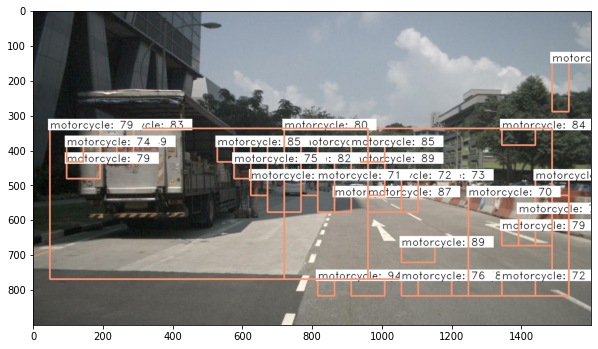

/content/samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402928112460.jpg
[('motorcycle', 99.48002099990845), ('motorcycle', 99.11909699440002), ('motorcycle', 96.41077518463135), ('motorcycle', 95.90556025505066), ('motorcycle', 95.10891437530518), ('motorcycle', 94.98254656791687), ('motorcycle', 94.14812326431274), ('motorcycle', 93.90220642089844), ('motorcycle', 92.21351146697998), ('motorcycle', 91.24305248260498), ('motorcycle', 91.09189510345459), ('motorcycle', 90.5066192150116), ('motorcycle', 89.92809653282166), ('motorcycle', 88.77099752426147), ('motorcycle', 87.8376305103302), ('motorcycle', 87.51234412193298), ('motorcycle', 86.7539644241333), ('motorcycle', 84.4663918018341), ('motorcycle', 83.8815689086914), ('motorcycle', 83.81078243255615), ('motorcycle', 82.83580541610718), ('motorcycle', 82.33122825622559), ('motorcycle', 80.87602257728577), ('motorcycle', 80.75827956199646), ('motorcycle', 78.56510877609253), ('motorcycle', 78.16893458366394), ('mo

/content/samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402928662460.jpg
[('motorcycle', 95.41188478469849), ('motorcycle', 93.90227794647217), ('motorcycle', 93.4885323047638), ('motorcycle', 93.12107563018799), ('motorcycle', 92.99079179763794), ('motorcycle', 92.19703674316406), ('motorcycle', 92.02558398246765), ('motorcycle', 91.16304516792297), ('motorcycle', 90.00272750854492), ('motorcycle', 89.40848708152771), ('motorcycle', 86.91434860229492), ('motorcycle', 86.61107420921326), ('motorcycle', 86.21898293495178), ('motorcycle', 83.12084674835205), ('motorcycle', 82.84953236579895), ('motorcycle', 82.50844478607178), ('motorcycle', 81.16452097892761), ('motorcycle', 80.32336235046387), ('motorcycle', 80.1979660987854), ('motorcycle', 79.6057641506195), ('motorcycle', 79.57538366317749), ('motorcycle', 77.7411699295044), ('motorcycle', 76.96665525436401), ('motorcycle', 75.29012560844421), ('motorcycle', 74.59198832511902), ('motorcycle', 74.43074584007263), ('m

/content/samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402929162460.jpg
[('motorcycle', 97.02419638633728), ('motorcycle', 97.01252579689026), ('motorcycle', 96.26501202583313), ('motorcycle', 95.51331996917725), ('motorcycle', 93.42104196548462), ('motorcycle', 90.53595662117004), ('motorcycle', 90.05631804466248), ('motorcycle', 89.85764384269714), ('motorcycle', 88.17223906517029), ('motorcycle', 86.5450382232666), ('motorcycle', 86.50936484336853), ('motorcycle', 86.46856546401978), ('motorcycle', 85.56172251701355), ('motorcycle', 84.80377793312073), ('motorcycle', 84.27689671516418), ('motorcycle', 84.09538269042969), ('motorcycle', 81.51044249534607), ('motorcycle', 80.159991979599), ('motorcycle', 79.83560562133789), ('motorcycle', 78.75906825065613), ('motorcycle', 77.96719074249268), ('motorcycle', 77.5482714176178), ('motorcycle', 77.29707360267639), ('motorcycle', 75.82155466079712), ('motorcycle', 75.55761933326721), ('motorcycle', 75.034099817276), ('mot

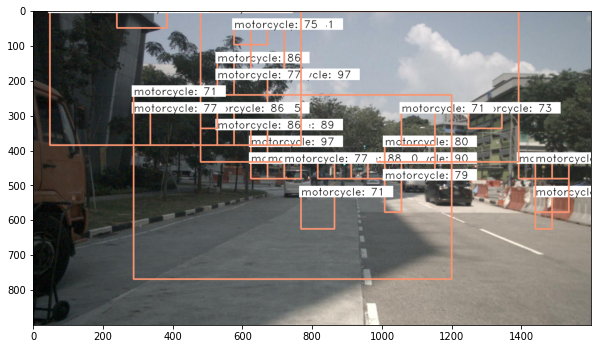

/content/samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402929662460.jpg


KeyboardInterrupt: ignored

In [40]:
bbox_threshold = 0.7
 
for idx, img_name in enumerate(imgs_path):
    print(img_name)
    st = time.time()
    
    # read image
    img = cv2.imread(img_name)
 
    # pre process image
    X, ratio = format_img(img)
    
    X = np.transpose(X, (0, 2, 3, 1))
 
    # Region Proposal Network prediction
    [Y1, Y2, F] = model_RPN.predict(X)
 
    # get bounding boxes
    R = rpn_to_roi(Y1, Y2, K.common.image_dim_ordering(), overlap_thresh=0.7)
 
    # convert bounding boxes coordinates
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]
 
    # spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}
 
    for jk in range(R.shape[0] // num_rois + 1):
        ROIs = np.expand_dims(R[num_rois * jk : num_rois * (jk + 1), :], axis=0)
        if ROIs.shape[1] == 0:
            break
 
        if jk == R.shape[0] // num_rois:
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0], num_rois, curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded
 
        # Classifier Model prediction
        [P_cls, P_regr] = model_Classifier_only.predict([F, ROIs])
 
        # calculate bounding boxes
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue
 
            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]
 
            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []
 
            (x, y, w, h) = ROIs[0, ii, :]
 
            cls_num = np.argmax(P_cls[0, ii, :])

            (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num : 4 * (cls_num + 1)]
            tx /= classifier_regr_std[0]
            ty /= classifier_regr_std[1]
            tw /= classifier_regr_std[2]
            th /= classifier_regr_std[3]
            x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)

            bboxes[cls_name].append([rpn_stride * x, rpn_stride * y, rpn_stride * (x + w), rpn_stride * (y + h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))
    all_dets = []
 
    for key in bboxes:
        bbox = np.array(bboxes[key])
 
        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]
 
            # get original shape image bounding boxes
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)
 
            cv2.rectangle(img, (real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])), 4)
 
            textLabel = '{}: {}'.format(key, int(100 * new_probs[jk]))
            all_dets.append((key, 100 * new_probs[jk]))
 
            retval, baseLine = cv2.getTextSize(textLabel, cv2.FONT_HERSHEY_COMPLEX, 1, 1)
            textOrg = (real_x1, real_y1 - 0)
 
            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1] + baseLine - 5), (textOrg[0] + retval[0] + 5, textOrg[1] - retval[1] - 5), (0, 0, 0), 1)
            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1] + baseLine - 5), (textOrg[0] + retval[0] + 5, textOrg[1] - retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)
    # print image bounding boxes with probability of hit
    print(all_dets)
    plt.figure(figsize=(10, 10))    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()